In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [3]:
class CNN(nn.Module):
    def __init__(self, input_x, input_dim, hidden_dims, output_dim, dropout):
        super(CNN, self).__init__()
        self.seq_len = input_x[-1]
        self.hidden_dims = hidden_dims
        
        # layer 1 (BatchNorm)
        self.layer1 = nn.BatchNorm2d(input_dim)     
        
        # layer 2 (Conv2d, tanh)
        self.layer2 = nn.Sequential(nn.Conv2d(input_dim, self.hidden_dims[1], kernel_size = (32, self.hidden_dims[0]), 
                                        stride = 1), nn.Tanh())     
        
        # layer 3 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer3_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2],kernel_size = (1, 5), 
                                        stride = (1, 5)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 10), 
                                        stride = (1, 10)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 15), 
                                        stride = (1, 15)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 4  (concat, dropout, tanh)
        
        # layer 5 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer5_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 2), 
                                        stride = (1, 2)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 4), 
                                        stride = (1, 4)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 11), 
                                        stride = (1, 11)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 6 (concat, dropout, tanh)
        
        # layer 7 (Maxpool, tanh, dropout)
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2)), nn.Tanh(), nn.Dropout2d(dropout))  
        
        # layer 8 (Flatten, tanh, dropout)
        self.layer8 = nn.Sequential(nn.Flatten(), nn.Linear(self.hidden_dims[3] * 62, 128), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 9 (Linear, Sigmoid)
        self.layer9 = nn.Sequential(nn.Linear(128, output_dim), nn.Sigmoid())
        
        self.dropout = nn.Sequential(nn.Dropout2d(dropout), nn.Tanh())
    
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out_3_1 = self.layer3_1(out)
        out_3_2 = self.layer3_2(out)
        out_3_3 = self.layer3_3(out)
        out = torch.cat((out_3_1, out_3_2, out_3_3),dim = 3)
        out = self.dropout(out)
        out_5_1 = self.layer5_1(out)
        out_5_2 = self.layer5_2(out)
        out_5_3 = self.layer5_3(out)
        out = torch.cat((out_5_1, out_5_2, out_5_3),dim = 3)
        out = self.dropout(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        
        return out

In [4]:
input_dim = 1
output_dim = 1
hidden_dims = [1, 128, 64, 32]
learning_rate = 0.0001
num_epochs = 50
dropout = 0.35

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
            

In [6]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
       # print("predictions",predictions)
        #print("labels", labels)
        predicted = predictions.round()
#         print("train predicted",predicted)
#         _, predicted = torch.max(predictions.data, 1) 
        #returns max value, indices
#         predicted = predicted.unsqueeze(1)
        total += labels.size(0)  #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
        correct += (predicted == labels).sum().item()
#         print("label",labels.size())
#         print("predicted", predicted.size())
#         print("correct", correct)
#         print("total", total)
#         print("acc", correct/ total)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
            # print("test predicted",predicted.T)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [7]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
from sklearn.model_selection import train_test_split


X = np.load('X_pool.npy')
y = np.load('y_pool.npy')
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (34236, 32, 410)
y.shape:  (34236,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train shape:  (27388, 1, 32, 410)
X_test shape:  (6848, 1, 32, 410)
y_train.shape:  (27388,)
y_test.shape:  (6848,)


In [10]:
train_acc_list = []
val_acc_list = []
subject_no_list = []
        
X = torch.Tensor(X_train)
y = torch.Tensor(y_train)
y = y-1
y = y.unsqueeze(1)
#         print(X.size())
#         print(y.size())

X_val = torch.Tensor(X_test)
y_val = torch.Tensor(y_test)
y_val = y_val-1
y_val = y_val.unsqueeze(1)
#         print(X_val.size())
#         print(y_val.size())

train_ds = TensorDataset(X, y)
valid_ds = TensorDataset(X_val, y_val)

        
BATCH_SIZE= 64

train_iterator = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

learning_rate=0.0001
epoches = 50
input_x = X.size()

model = CNN(input_x, input_dim, hidden_dims, output_dim, dropout).to(device)
model.apply(initialize_weights)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

N_EPOCHS = 100

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")

#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    if train_acc > 95 and valid_acc > 93 and valid_loss <= 0.20:
        N_EPOCHS = epoch
        break

# to save in excel
train_acc_list.append(train_acc)
val_acc_list.append(valid_acc)

CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 10), stride=(1, 10))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3_3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 15), stride=(1, 15))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer5_1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 2), stride=(1, 2))


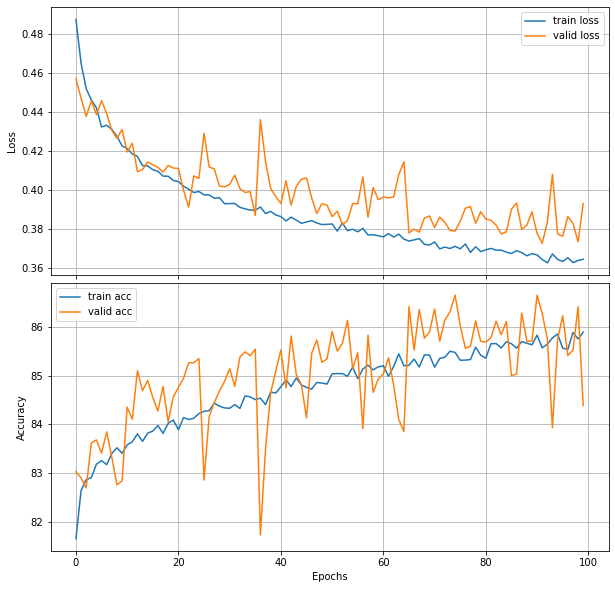

In [11]:
#to plot
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

In [13]:
num_parameters = sum(p.numel() for p in model.parameters())
print("Total number of parameters in CNN Conv2d model is {}".format(num_parameters))

Total number of parameters in CNN Conv2d model is 539875


## Save accuracy for both train and val in excel

In [12]:
# import xlsxwriter

# workbook = xlsxwriter.Workbook('Conv2D ACC.xlsx')
# worksheet = workbook.add_worksheet()

# worksheet.write(0, 0, 'Subject No')
# worksheet.write(0, 1, 'Train Accuracy')
# worksheet.write(0, 2, 'Val Accuracy')

# for i in range(len(train_acc_list)):
#     worksheet.write(i+1, 0, subject_no_list[i])
#     worksheet.write(i+1, 1, train_acc_list[i]) 
#     worksheet.write(i+1, 2, val_acc_list[i])
    
# workbook.close()